Epoch 1/500


c:\Users\Natha\anaconda3\envs\IR_pv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


243/243 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0487 - val_loss: 0.0458
Epoch 2/500
243/243 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0387 - val_loss: 0.0361
Epoch 3/500
243/243 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0361 - val_loss: 0.0389
Epoch 4/500
243/243 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0352 - val_loss: 0.0362
Epoch 5/500
243/243 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0352 - val_loss: 0.0357
Epoch 6/500
243/243 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0347 - val_loss: 0.0370
Epoch 7/500
243/243 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0337 - val_loss: 0.0366
Epoch 8/500
243/243 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0378 - val_loss: 0.0351
Epoch 9/500
243/243 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0327 - val_loss: 0.0355
Epoch 10/500
243/243 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0336 - val_loss: 0.0358
Epoch 11/500
243/243 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0347 - val_loss: 0.0373
Epoch 12/500
243/243 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step

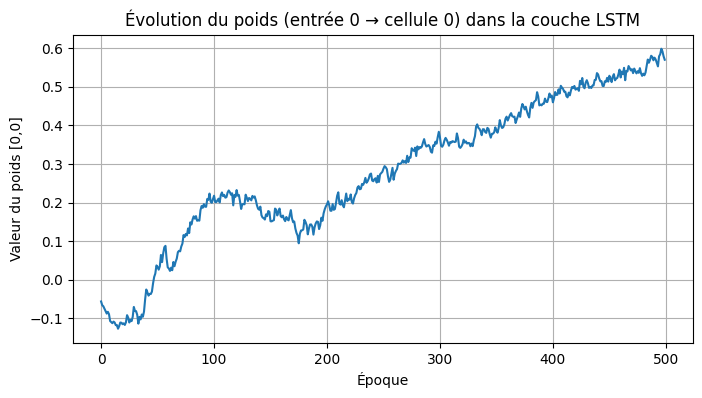

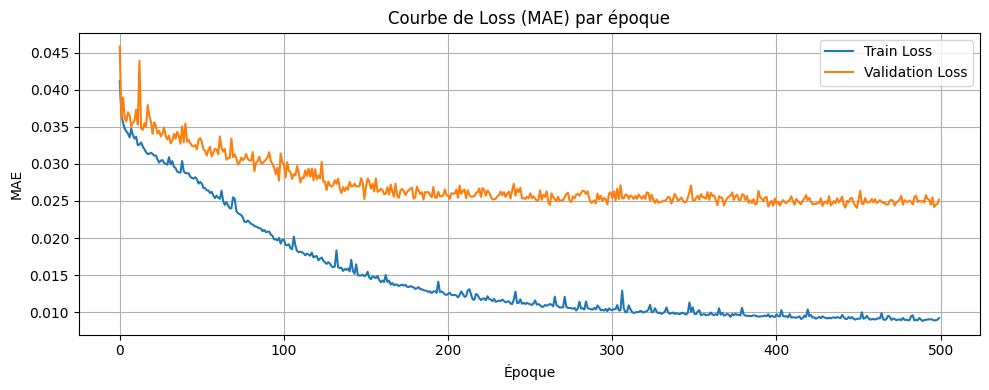

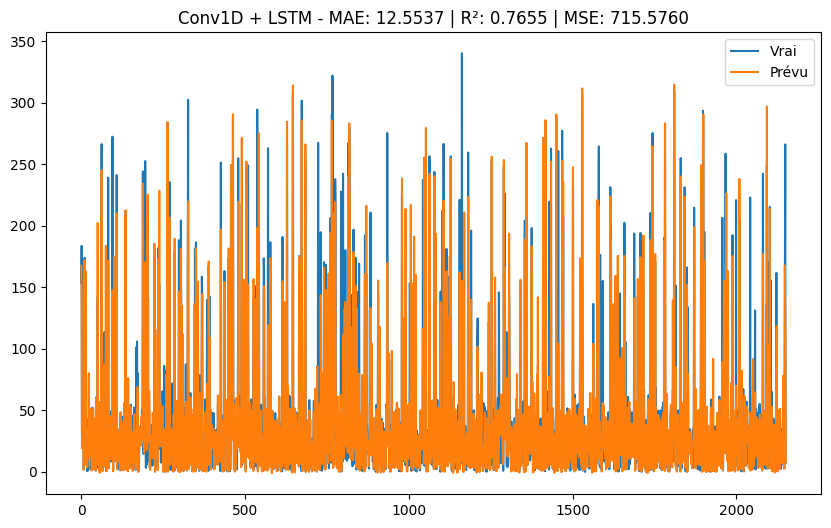

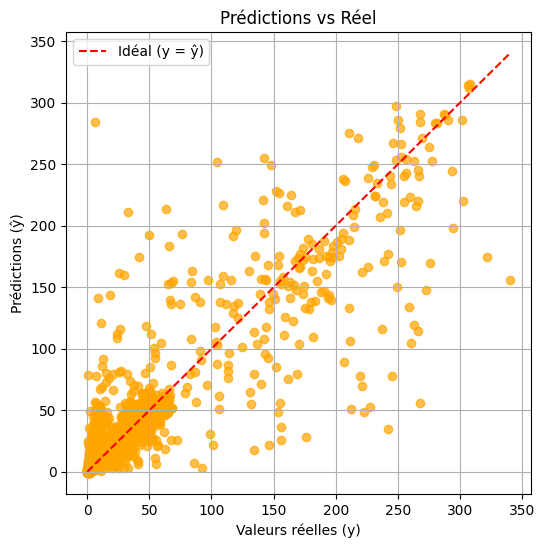

MAE: 12.5537, MSE: 715.5760, R²: 0.7655


In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, LSTM, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score

# === CALLBACK pour suivre les poids ===
class WeightLogger(Callback):
    def __init__(self, layer_name="lstm"):
        super().__init__()
        self.layer_name = layer_name
        self.weights_per_epoch = []

    def on_epoch_end(self, epoch, logs=None):
        for layer in self.model.layers:
            if self.layer_name in layer.name.lower():
                weights = layer.get_weights()[0]
                self.weights_per_epoch.append(weights.copy())
                break

# === 1. Chargement des données ===
def load_data(csv_path,ws):
    df = pd.read_csv(csv_path)
    # === 2. Normalisation ===
    scaler = MinMaxScaler()
    scaled_df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
    y_scaled = scaled_df['production']
    X_scaled = scaled_df.drop(columns=['production'])
    # === 3. Séquences temporelles ===
    def create_sequences(X, y, window_size=21):
        Xs, ys = [], []
        for i in range(len(X) - window_size):
            Xs.append(X[i:i + window_size])
            ys.append(y[i + window_size])
        return np.array(Xs), np.array(ys)

    window_size = ws
    X_seq, y_seq = create_sequences(X_scaled, y_scaled, window_size)
    return X_seq, y_seq, scaler,scaled_df

# === 2. Model ConvLSTM1D ===
def model_convlstm1d(X_seq, y_seq,epoch,batch_sizes):
    # === 4. Split ===
    X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42)

    # === 5. Modèle Conv1D + LSTM ===
    model = Sequential([
        Conv1D(filters=128, kernel_size=5, activation='relu', padding='same', input_shape=(X_train.shape[1], X_train.shape[2])),
        LSTM(64, return_sequences=False),
        Dense(32, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer=Adam(0.001), loss='mae')

    # === 6. Entraînement ===
    weight_logger = WeightLogger(layer_name="lstm")

    history = model.fit(
        X_train, y_train,
        epochs=epoch,
        batch_size=batch_sizes,
        validation_split=0.1,
        verbose=1,
        callbacks=[weight_logger]
    )

    # === 7. Prédictions ===
    y_pred = model.predict(X_test).flatten()

    return model, history, y_pred, y_test, weight_logger

# === 3. Performance model ===
def plot_function(scaled_data, y_pred, y_test, scaler, weight_logger,history):
    # Inverse scaling
    n_features = scaled_data.shape[1]
    dummy = np.zeros((len(y_pred), n_features))
    target_idx = scaled_data.columns.get_loc('production')  # ou passe target_col en argument
    dummy[:, target_idx] = y_pred
    y_pred_real = scaler.inverse_transform(dummy)[:, target_idx]

    dummy_test = np.zeros((len(y_test), n_features))
    dummy_test[:, target_idx] = y_test
    y_test_real = scaler.inverse_transform(dummy_test)[:, target_idx]

    mae = mean_absolute_error(y_test_real, y_pred_real)
    mse = np.mean((y_test_real - y_pred_real) ** 2)
    r2 = r2_score(y_test_real, y_pred_real)

    # === 8. Visualisations ===

    # Évolution d’un poids
    w00 = [w[0, 0] for w in weight_logger.weights_per_epoch]
    plt.figure(figsize=(8, 4))
    plt.plot(w00)
    plt.xlabel("Époque")
    plt.ylabel("Valeur du poids [0,0]")
    plt.title("Évolution du poids (entrée 0 → cellule 0) dans la couche LSTM")
    plt.grid(True)
    plt.show()

    # Courbe loss
    plt.figure(figsize=(10, 4))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Courbe de Loss (MAE) par époque')
    plt.xlabel('Époque')
    plt.ylabel('MAE')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Réel vs Prévu
    plt.figure(figsize=(10, 6))
    plt.plot(y_test_real, label="Vrai")
    plt.plot(y_pred_real, label="Prévu")
    plt.legend()
    plt.title(f"Conv1D + LSTM - MAE: {mae:.4f} | R²: {r2:.4f} | MSE: {mse:.4f}")
    plt.show()

    # Scatter plot
    plt.figure(figsize=(6, 6))
    plt.scatter(y_test_real, y_pred_real, alpha=0.7, color='orange')
    plt.plot([min(y_test_real), max(y_test_real)], [min(y_test_real), max(y_test_real)], 'r--', label="Idéal (y = ŷ)")
    plt.xlabel("Valeurs réelles (y)")
    plt.ylabel("Prédictions (ŷ)")
    plt.title("Prédictions vs Réel")
    plt.legend()
    plt.grid(True)
    plt.show()
    return mae, mse, r2

# === 4. Main ===
def main():
    csv_path = "../DataCleaning/scaled_dataset.csv"
    window_size = 21
    X_seq, y_seq, scaler, scaled_data = load_data(csv_path, window_size)
    model, history, y_pred, y_test, weight_logger = model_convlstm1d(X_seq, y_seq,epoch=500,batch_sizes=32)
    mae, mse, r2 = plot_function(scaled_data, y_pred, y_test, scaler, weight_logger, history)
    print(f"MAE: {mae:.4f}, MSE: {mse:.4f}, R²: {r2:.4f}")

if __name__ == "__main__":
    main()


Affichage stats

            Y_test       Y_pred        Error  Error_Percent
count  2152.000000  2152.000000  2152.000000    2152.000000
mean     63.128694    63.203709    -0.075015       2.406169
std      18.008118    17.681008     3.868485       6.922391
min      13.500000    13.271107   -30.011768       0.001350
25%      48.631250    49.082197    -0.429076       0.272020
50%      64.650000    65.060512    -0.047581       0.614518
75%      79.206250    78.691447     0.316948       1.333222
max      96.175000    94.800278    38.687379      88.794619


<Axes: >

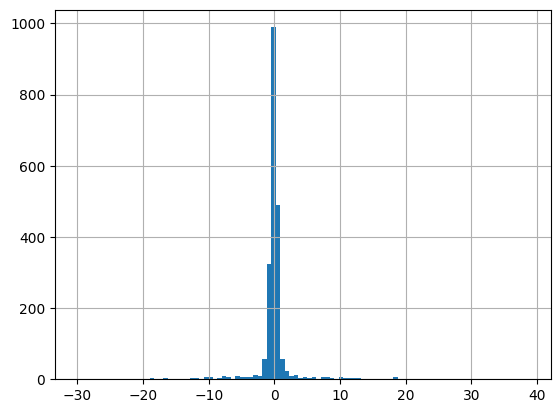

In [9]:
StatsDf = pd.DataFrame({
    "Y_test": y_test_real,
    "Y_pred": y_pred_real,
    "Error": y_test_real - y_pred_real,
    "Error_Percent": abs(y_test_real - y_pred_real) / y_test_real * 100
})

print(StatsDf.describe())
StatsDf["Error"].hist(bins=100)
